In [ ]:
2from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3)

data = pd.read_csv("/content/drive/MyDrive/BIA_667_Intro_DL/assignments/assignment4/homework_4/Processed_S&P.csv", parse_dates=[0])
data = data[["Date", "Close", "Volume", \
             "mom", "mom1", "mom2", "mom3",\
            "ROC_5","ROC_10","ROC_15","ROC_20",\
            "EMA_10","EMA_20","EMA_50"]]

# drop NA
data = data.dropna(axis = 0)
print("Start date: ", data["Date"].min())
print("End date: ", data["Date"].max())
print(len(data))
data.head(10)

Start date:  2010-03-15 00:00:00
End date:  2017-11-15 00:00:00
1935


,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50
49,2010-03-15,1150.510010,-0.155038,0.000452,-0.000217,0.004042,0.004525,1.054898,3.119095,3.835705,6.973436,1137.793700,1125.859965,1112.939394
50,2010-03-16,1159.459961,0.049389,0.007779,0.000452,-0.000217,0.004042,1.666887,3.679651,5.925451,5.899327,1141.733020,1129.059965,1114.763730
51,2010-03-17,1166.209961,0.135803,0.005822,0.007779,0.000452,-0.000217,1.798167,4.238501,5.516446,6.066334,1146.183373,1132.598059,1116.781230
52,2010-03-18,1165.829956,-0.146819,-0.000326,0.005822,0.007779,0.000452,1.355366,3.816664,5.702034,5.338148,1149.755479,1135.763002,1118.704709
53,2010-03-19,1159.900024,0.230936,-0.005086,-0.000326,0.005822,0.007779,0.861750,1.861779,5.016798,4.573688,1151.599942,1138.061766,1120.320212
54,2010-03-22,1165.810059,-0.182397,0.005095,-0.005086,-0.000326,0.005822,1.329849,2.398775,4.490423,5.216564,1154.183599,1140.704461,1122.104127
55,2010-03-23,1174.170044,0.035188,0.007171,0.005095,-0.005086,-0.000326,1.268701,2.956736,4.995036,7.269328,1157.817498,1143.891659,1124.145928
56,2010-03-24,1167.719971,0.066667,-0.005493,0.007171,0.005095,-0.005086,0.129480,1.929975,4.373469,5.653069,1159.617948,1146.161022,1125.854714
57,2010-03-25,1165.729980,0.204675,-0.001704,-0.005493,0.007171,0.005095,-0.008576,1.346675,3.807761,5.692970,1160.729226,1148.024732,1127.418450
58,2010-03-26,1166.589966,-0.169430,0.000738,-0.001704,-0.005493,0.007171,0.576769,1.443489,2.449286,5.622502,1161.794815,1149.792850,1128.954588


In [ ]:
def sliding_windows(data_win, window):
    x = []
    for i in range(window, len(data_win)):
        x.append(data_win[i-window:i])
    return np.array(x)

def binary_labels(Y, offset=0):
    y = []
    cnt = 0 
    for i in range(len(Y)-1):
        cnt += 1
        # print(i, i+1, Y[i], Y[i+1])
        if Y[i] < Y[i+1]:
            y.append(1)
        else:
            y.append(0)
    return np.array(y)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def transform_data(data, feature_cols, target_col, cut_off_index, lookback=5):
    train, test  = data[:cut_off_index], data[cut_off_index:]

    scalarX = StandardScaler()
    scalar_x = scalarX.fit(train[feature_cols])
    scalarY = StandardScaler()
    scalar_y = scalarY.fit(train[target_col].to_numpy().reshape(-1,1))

    scaled_X = scalar_x.transform(data[feature_cols])
    Y = scalar_y.transform(data[target_col].to_numpy().reshape(-1,1))
    X = sliding_windows(scaled_X, lookback)
    Y_binary = binary_labels(Y[4:])
    
    return X, Y[lookback:], Y_binary, scalar_x, scalar_y

In [ ]:
feature_cols = ["Close","Volume", "mom", "mom1", "mom2", "mom3","ROC_5","ROC_10","ROC_15","ROC_20","EMA_10","EMA_20","EMA_50"]  
# feel free to add your own features, e.g. volume, day, week, etc.
target_col = "Close"
lookback = 5
train_test_cut_off = int(len(data)*0.8)
X, Y, Y_binary, scalar_x, scalar_y = transform_data(data, feature_cols, target_col, train_test_cut_off, lookback=lookback)
print("Total samples: {0}, train: {1}, test: {2}\n".format(len(X), train_test_cut_off, len(X)- train_test_cut_off))
print("Show a few observations:")
print("Before transformation:")
print(data.iloc[0:7,0:3])
print("\nAfter transformation:")
print("X:")
print(X[0:2,:,0:2])
print("\nY - Regression:")
print(Y[0:2])
print("\nY - Classification: buy or hold")
print(Y_binary[0:2])

Total samples: 1930, train: 1548, test: 382

Show a few observations:
Before transformation:
         Date        Close    Volume
49 2010-03-15  1150.510010 -0.155038
50 2010-03-16  1159.459961  0.049389
51 2010-03-17  1166.209961  0.135803
52 2010-03-18  1165.829956 -0.146819
53 2010-03-19  1159.900024  0.230936
54 2010-03-22  1165.810059 -0.182397
55 2010-03-23  1174.170044  0.035188

After transformation:
X:
[[[-1.327 -0.796]
  [-1.301  0.138]
  [-1.282  0.533]
  [-1.283 -0.758]
  [-1.3    0.967]]

 [[-1.301  0.138]
  [-1.282  0.533]
  [-1.283 -0.758]
  [-1.3    0.967]
  [-1.283 -0.921]]]

Y - Regression:
[[-1.283]
 [-1.259]]

Y - Classification: buy or hold
[1 1]


In [ ]:
# print(X.shape, Y.shape, Y_binary.shape)
# Y = Y[lookback:] # drop the first 4 rows as first 0,1,2,3,4 are used to predict the 5th 
# Y_binary = Y_binary[lookback:] # drop 0,1,2,3, as we compare 4, 5 to predict 5th 
print(X.shape, Y.shape, Y_binary.shape)
# do not have to drop as the last elem in y_pred also cant be used to predict the next elem

(1930, 5, 13) (1930, 1) (1930,)


In [ ]:
# Define a function to calculate a baseline on the testing data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
def evaluate_naive_method(test_X, test_Y, test_Y_binary):
    y_pred = test_X.mean(axis = 1)
    mae = mean_absolute_error(test_Y, y_pred)
    y_pred_binary = binary_labels(y_pred)
    print("evaluate y_pred", y_pred_binary.shape)
    print("evaluate real test_Y_binary", test_Y_binary.shape)
    acc = accuracy_score(test_Y_binary[:-1], y_pred_binary)
    return mae, acc

In [ ]:
test_X = X[train_test_cut_off:]
test_Y = Y[train_test_cut_off:]
test_Y_binary = Y_binary[train_test_cut_off:]
print("X",test_X.shape, "Y", test_Y.shape, "yb",test_Y_binary.shape)
mae, acc = evaluate_naive_method(test_X[:,:,0], test_Y, test_Y_binary)
print("mae: {0:.3f}, acc: {1:.3f}".format(mae, acc))

X (382, 5, 13) Y (382, 1) yb (382,)
evaluate y_pred (381,)
evaluate real test_Y_binary (382,)
mae: 0.036, acc: 0.672


# Q3 First RNN with PyTorch

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import numpy as np

In [ ]:
class SP_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(SP_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim


        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            layer_dim, 
            batch_first=True, 
            dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
      # if torch.cuda.is_available():
      #   model.cuda()
      #   inputs = inputs.cuda() 
      #   target = target.cuda()

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)


        return out

In [ ]:
class SP_dataset(Dataset):
    def __init__(self, X, Y, Y_binary):
        self.X = torch.tensor(X, dtype=torch.float)
        self.Y = torch.tensor(Y, dtype=torch.float)
        self.Y_binary = torch.tensor(Y_binary).float()
        self.len = len(X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index], self.Y_binary[index]
    def __len__(self):
        return self.len

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            # self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
from sklearn.metrics import accuracy_score
# # Define a function to train the model 
def train_model(model, train_dataset, test_dataset, device, binary_pred = False,\
                lr=0.0005, epochs=20, batch_size=32):
    # Define the loss function
    if binary_pred:
        # criterion = nn.BCELoss()
        criterion = nn.BCEWithLogitsLoss()
    else:
        # criterion = nn.L1Loss()
        criterion = nn.MSELoss()


    # Define the optimizer
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Define the dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    # Train the model
    model = model.to(device)
    early_stopping = EarlyStopping(patience=10, verbose=True)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                               patience=10,
                                                               threshold=0.001,
                                                               threshold_mode='rel',
                                                               cooldown=0,
                                                               min_lr=0.00001,
                                                               eps=1e-08,
                                                               verbose=True)

    train_history = {'train_loss': [],
                    'train_acc': [],
                    'test_loss': [],
                    'test_acc': []}
    loss_list = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        val_acc = 0
        for x,y, y_binary in train_loader:
            x = x.to(device)
            y = y.to(device)
            y_binary = y_binary.to(device)
            outputs = model(x)
            
            
            if binary_pred:
                output = outputs.view(-1)
                predicted = torch.sigmoid(output)
                
                # predicted = output
                cur_train_loss = criterion(predicted, y_binary)
                train_loss += cur_train_loss
                
                # pred_bin = np.round(predicted.cpu().detach().numpy())
                pred_bin = (predicted.cpu().detach().numpy() > 0.5)
                # y_bin = y_binary.detach().cpu().numpy()
                # pred_bin = pred_bin.detach.cpu().numpy()
                # print(y_binary)
                y_binary = y_binary.cpu().detach().numpy()
                # print(pred_bin)
                acc_score = accuracy_score(y_binary, pred_bin)
                train_acc +=  acc_score
                
            else:
                cur_train_loss = criterion(outputs, y)
                train_loss += cur_train_loss

            loss_list.append(cur_train_loss.item())
            cur_train_loss.backward()
            scheduler.step(np.array(loss_list).mean())
            optimizer.step()
            optimizer.zero_grad()
             
        
        
        model.eval()
        with torch.no_grad():
            for x, y, y_binary in test_loader: # ignore binary label
                # move
                x = x.to(device)
                y = y.to(device)
                y_binary = y_binary.to(device)
                outputs = model(x)

                if binary_pred:
                    output = outputs.view(-1)
                    predicted = torch.sigmoid(output)
                    # predicted = output
                    cur_train_loss = criterion(predicted, y_binary)
                    test_loss += cur_train_loss
                    
                    pred_bin = (predicted.cpu().detach().numpy() > 0.5)                
                    y_binary = y_binary.cpu().detach().numpy()
                    acc_score = accuracy_score(y_binary, pred_bin)
                    test_acc +=  acc_score
                    
                else:
                    cur_test_loss = criterion(outputs, y)
                    test_loss += cur_test_loss  # sum up batch loss

        
        train_loss = (train_loss/len(train_loader))
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader))
        val_acc = test_acc/len(test_loader)

        train_history['train_loss'].append(train_loss)
        train_history['train_acc'].append(train_acc)
        train_history['test_loss'].append(val_loss)
        train_history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train_loss:{train_loss:.5f} train_acc:{train_acc:.5f}, test_loss:{val_loss:.5f} test_acc:{val_acc:.5f}")
        # display.clear_output(wait=True)

        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
 
    return train_history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = X[:train_test_cut_off]
Y_train = Y[:train_test_cut_off]
Y_binary_train = Y_binary[:train_test_cut_off]
train_dataset = SP_dataset(X_train, Y_train, Y_binary_train)


X_test = X[train_test_cut_off:]
Y_test = Y[train_test_cut_off:]
Y_binary_test = Y_binary[train_test_cut_off:]
test_dataset = SP_dataset(X_test, Y_test, Y_binary_test)


input_dim = len(feature_cols)
hidden_dim = 128
output_dim = 1
num_layers = 2
dropout = 0.25
model_reg = SP_Model(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=num_layers, output_dim=output_dim, dropout_prob=dropout)
hista = train_model(model_reg, train_dataset, test_dataset, device, binary_pred = False,lr=0.0005, epochs=100, batch_size=32)


Epoch:1 / 100, train_loss:0.33727 train_acc:0.00000, test_loss:0.33356 test_acc:0.00000
Epoch:2 / 100, train_loss:0.01035 train_acc:0.00000, test_loss:0.23356 test_acc:0.00000
Validation loss decreased (inf --> 2.802717).  Saving model ...
Epoch:3 / 100, train_loss:0.00705 train_acc:0.00000, test_loss:0.18622 test_acc:0.00000
Validation loss decreased (2.802717 --> 2.234683).  Saving model ...
Epoch:4 / 100, train_loss:0.00594 train_acc:0.00000, test_loss:0.15634 test_acc:0.00000
Validation loss decreased (2.234683 --> 1.876125).  Saving model ...
Epoch:5 / 100, train_loss:0.00518 train_acc:0.00000, test_loss:0.08773 test_acc:0.00000
Validation loss decreased (1.876125 --> 1.052776).  Saving model ...
Epoch:6 / 100, train_loss:0.00482 train_acc:0.00000, test_loss:0.04822 test_acc:0.00000
Validation loss decreased (1.052776 --> 0.578631).  Saving model ...
Epoch:7 / 100, train_loss:0.00423 train_acc:0.00000, test_loss:0.05089 test_acc:0.00000
EarlyStopping counter: 1 out of 10
Epoch:8 /

In [ ]:
input_dim = len(feature_cols)
hidden_dim = 64
output_dim = 1
num_layers = 2
dropout = 0.25
model_classification = SP_Model(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=num_layers, output_dim=1, dropout_prob=dropout)
histb = train_model(model_classification, train_dataset, test_dataset, device, binary_pred = True,lr=0.001, epochs=100, batch_size=32)

Epoch    14: reducing learning rate of group 0 to 5.0000e-04.
Epoch    25: reducing learning rate of group 0 to 2.5000e-04.
Epoch    36: reducing learning rate of group 0 to 1.2500e-04.
Epoch    47: reducing learning rate of group 0 to 6.2500e-05.
Epoch:1 / 100, train_loss:0.70213 train_acc:0.51573, test_loss:0.69295 test_acc:0.45017
Epoch    58: reducing learning rate of group 0 to 3.1250e-05.
Epoch    69: reducing learning rate of group 0 to 1.5625e-05.
Epoch    80: reducing learning rate of group 0 to 1.0000e-05.
Epoch:2 / 100, train_loss:0.69893 train_acc:0.46344, test_loss:0.69254 test_acc:0.45052
Validation loss decreased (inf --> 8.310524).  Saving model ...
Epoch:3 / 100, train_loss:0.69999 train_acc:0.46726, test_loss:0.69226 test_acc:0.45035
Validation loss decreased (8.310524 --> 8.307158).  Saving model ...
Epoch:4 / 100, train_loss:0.69911 train_acc:0.46556, test_loss:0.69216 test_acc:0.45069
Validation loss decreased (8.307158 --> 8.305895).  Saving model ...
Epoch:5 / 10

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history, binary_pred):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='train_loss')
    plt.plot(epochs, history['test_loss'], 'r-', label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    if binary_pred:
        epochs = range(1, len(history['train_acc']) + 1)
        plt.plot(epochs, history['train_acc'], 'b-', label='train_acc')
        plt.plot(epochs, history['test_acc'], 'r-', label='test_acc')

        plt.title('Test Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Acc')
        plt.legend()

        plt.show()

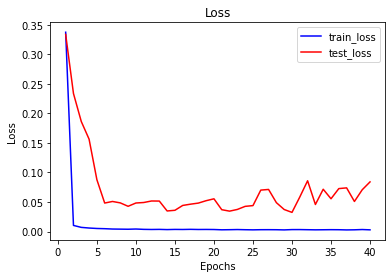

In [ ]:
plot_history(hista, binary_pred = False)

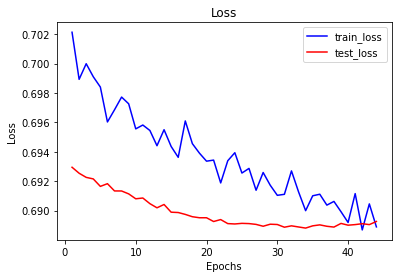

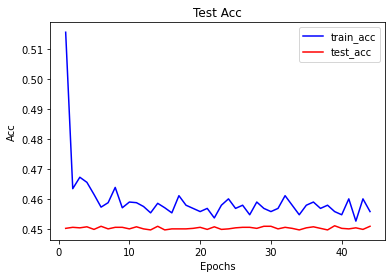

In [ ]:
plot_history(histb, binary_pred = True)

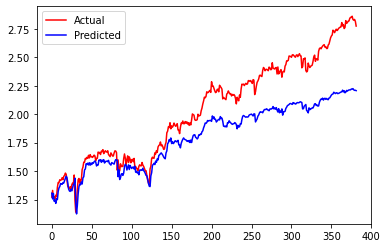

In [ ]:
lld = train_loader = DataLoader(test_dataset, batch_size=386, shuffle=False)
predications = []
for x, y, y_binary in lld:
    x = x.to(device)
    y = y.to(device)
    preds = model_reg(x).cuda()
    predications.extend(preds)
Y_actual = pd.DataFrame(Y_test)

from matplotlib import pyplot as plt
plt.plot(Y_actual, label='Actual', color='red')
plt.plot(predications, label='Predicted', color='blue')
plt.legend()
plt.show()

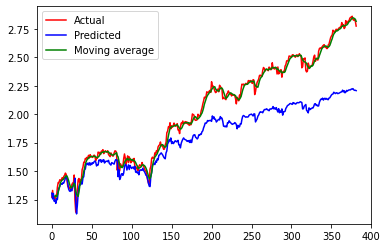

In [ ]:
y = pd.DataFrame(y)
moving_avg= y.rolling(window=5).mean() 

lld = train_loader = DataLoader(test_dataset, batch_size=386, shuffle=False)
predications = []
for x, y, y_binary in lld:
    x = x.to(device)
    y = y.to(device)
    preds = model_reg(x).cuda()
    predications.extend(preds)
Y_actual = pd.DataFrame(Y_test)

from matplotlib import pyplot as plt
plt.plot(Y_actual, label='Actual', color='red')
plt.plot(predications, label='Predicted', color='blue')
plt.plot(moving_avg, label='Moving average', color='green')
plt.legend()
plt.show()

In [ ]:
class SP_Model_Advanced(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(SP_Model_Advanced, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.c1 = nn.Conv1d(in_channels=5, out_channels=hidden_dim, kernel_size=2)
        self.p1 = nn.MaxPool1d(2)
        self.c2 = nn.Conv1d(hidden_dim, hidden_dim, 1)
        self.p2 = nn.MaxPool1d(2)
        self.c3 = nn.Conv1d(hidden_dim, hidden_dim, 1)
        self.p3 = nn.MaxPool1d(2)

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=layer_dim, 
            batch_first=True, 
            dropout=dropout_prob,
            bidirectional=True
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
    def forward(self, x):
        
        # Run through Conv1d and Pool1d layers
        c = self.c1(x)
        p = self.p1(c)

        c = self.c2(p)
        p = self.p2(c)

        c = self.c3(p)
        p = self.p3(c)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        # print(out.shape)
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [ ]:
input_dim = len(feature_cols)
hidden_dim = 256
output_dim = 1
num_layers = 3
dropout = 0.25
print(X_test.shape)
model_reg_adv = SP_Model_Advanced(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=num_layers, output_dim=output_dim, dropout_prob=dropout)
hista_adv = train_model(model_reg_adv, train_dataset, test_dataset, device, binary_pred = False,lr=0.0005, epochs=100, batch_size=64)


(382, 5, 13)
Epoch:1 / 100, train_loss:0.31769 train_acc:0.00000, test_loss:0.43042 test_acc:0.00000
Epoch:2 / 100, train_loss:0.01617 train_acc:0.00000, test_loss:0.19058 test_acc:0.00000
Validation loss decreased (inf --> 1.143497).  Saving model ...
Epoch:3 / 100, train_loss:0.00734 train_acc:0.00000, test_loss:0.21013 test_acc:0.00000
EarlyStopping counter: 1 out of 10
Epoch:4 / 100, train_loss:0.00532 train_acc:0.00000, test_loss:0.14887 test_acc:0.00000
Validation loss decreased (1.143497 --> 0.893194).  Saving model ...
Epoch:5 / 100, train_loss:0.00459 train_acc:0.00000, test_loss:0.17568 test_acc:0.00000
EarlyStopping counter: 1 out of 10
Epoch:6 / 100, train_loss:0.00412 train_acc:0.00000, test_loss:0.12878 test_acc:0.00000
Validation loss decreased (0.893194 --> 0.772651).  Saving model ...
Epoch:7 / 100, train_loss:0.00364 train_acc:0.00000, test_loss:0.10156 test_acc:0.00000
Validation loss decreased (0.772651 --> 0.609331).  Saving model ...
Epoch:8 / 100, train_loss:0.00

In [ ]:
input_dim = len(feature_cols)
hidden_dim = 64
output_dim = 1
num_layers = 5
dropout = 0.2
model_classification_adv = SP_Model_Advanced(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=num_layers, output_dim=1, dropout_prob=dropout)
histb_adv = train_model(model_classification_adv, train_dataset, test_dataset, device, binary_pred = True,lr=0.0005, epochs=50, batch_size=32)

Epoch    14: reducing learning rate of group 0 to 2.5000e-04.
Epoch    25: reducing learning rate of group 0 to 1.2500e-04.
Epoch    36: reducing learning rate of group 0 to 6.2500e-05.
Epoch    47: reducing learning rate of group 0 to 3.1250e-05.
Epoch:1 / 50, train_loss:0.69925 train_acc:0.46216, test_loss:0.69287 test_acc:0.45017
Epoch    58: reducing learning rate of group 0 to 1.5625e-05.
Epoch    69: reducing learning rate of group 0 to 1.0000e-05.
Epoch:2 / 50, train_loss:0.69605 train_acc:0.45897, test_loss:0.69259 test_acc:0.45052
Validation loss decreased (inf --> 8.311028).  Saving model ...
Epoch:3 / 50, train_loss:0.69652 train_acc:0.46110, test_loss:0.69202 test_acc:0.44983
Validation loss decreased (8.311028 --> 8.304274).  Saving model ...
Epoch:4 / 50, train_loss:0.69456 train_acc:0.45685, test_loss:0.69200 test_acc:0.45052
Validation loss decreased (8.304274 --> 8.303960).  Saving model ...
Epoch:5 / 50, train_loss:0.69349 train_acc:0.45472, test_loss:0.69126 test_acc

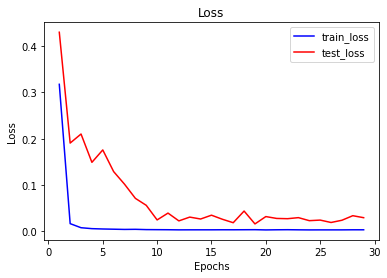

In [ ]:
plot_history(hista_adv, binary_pred = False)

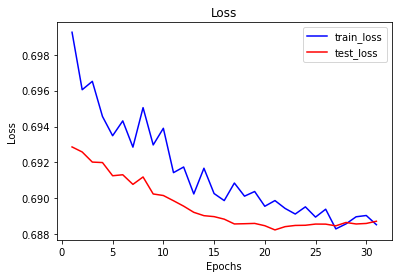

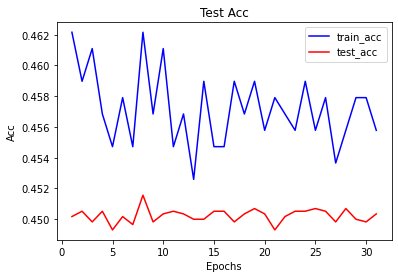

In [ ]:
plot_history(histb_adv, binary_pred = True)

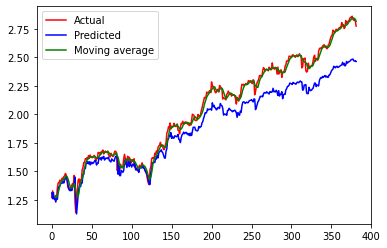

In [ ]:
y = pd.DataFrame(y)
moving_avg= y.rolling(window=5).mean()

lld = train_loader = DataLoader(test_dataset, batch_size=386, shuffle=False)
predications = []
for x, y, y_binary in lld:
    x = x.to(device)
    y = y.to(device)
    preds=model_reg_adv(x).cuda()
    predications.extend(preds)
Y_actual = pd.DataFrame(Y_test)

from matplotlib import pyplot as plt
plt.plot(Y_actual, label='Actual', color='red')
plt.plot(predications, label='Predicted', color='blue')
plt.plot(moving_avg, label='Moving average', color='green')
plt.legend()
plt.show()